In [157]:
from __future__ import print_function
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
import versor as vsr
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')
from versor.drawing import *
from motor_estimation import MotorEstimationSolver
from game import VDMotorEstimationSolver
from icp import best_fit_transform

Populating the interactive namespace from numpy and matplotlib


/Users/lars/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['median', 'Inf', 'norm', 'argmax', 'argmin']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Generate motors

In [158]:
def create_motors(n_motors=10, d_lims=(-1,1), th_lims=(-pi,pi)):
    motors = [((vsr.Vec(*np.random.random(3)).unit() * np.random.uniform(*d_lims)).trs() * 
               vsr.Rot(vsr.Biv(*np.random.uniform(-1,1,3)).unit() * np.random.uniform(*th_lims) * -0.5)) 
              for i in range(n_motors)]
    return motors

In [159]:
def create_gaussian_points(motor, n_points=10, points_std=0.8, noise_std=0.09):
    points = []
    for i in range(n_points):
        a = vsr.Vec(*np.random.normal(0.0, points_std,3)).null()
        b = a.spin(motor)
        bn = vsr.Vec(*(np.array(b)[:3] + np.random.normal(0,noise_std,3))).null()
        points.append((a,b,bn))
    return (points, motor)

In [160]:
def estimate_motors(dataset, 
                    initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                    noisy=False):
    points, motor = dataset
    mes = MotorEstimationSolver(initial_motor)
    if noisy:
        for (a, _, bn) in points:
            mes.add_point_correspondences_residual_block(a,bn)
    else:
        for (a, b, _) in points:
            mes.add_point_correspondences_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = 'DENSE_QR'
    (estimated_motor, summary, _) = mes.solve()
    return (points, motor, estimated_motor, summary)

In [161]:
def estimate_motors_vd(dataset, 
                       initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                       noisy=False):
    vd = VDMotorEstimationSolver()
    points, motor = dataset
    points_a = []
    points_b = []
    points_bn = []
    for (a,b,bn) in points:
        points_a.append(a)
        points_b.append(b)
        points_bn.append(bn)
    if noisy:
        vd.add_point_observations(points_a, points_bn)
    else:
        vd.add_point_observations(points_a, points_b)
    estimated_motor = vd.solve()
    return (points, motor, estimated_motor, [])

In [162]:
def estimate_motors_svd(dataset, 
                        initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                        noisy=False):
    def log(R):
        # Rotation matrix logarithm
        theta = np.arccos((R[0,0] + R[1,1] + R[2,2] - 1.0)/2.0)
        return np.array([R[2,1] - R[1,2], R[0,2] - R[2,0], R[1,0] - R[0,1]]) * theta / (2*np.sin(theta))
    points, motor = dataset
    points_a_np = []
    points_b_np = []
    points_bn_np = []
    for (a,b,bn) in points:
        points_a_np.append(np.array(a.vec()))
        points_b_np.append(np.array(b.vec()))
        points_bn_np.append(np.array(bn.vec()))
    points_a_np = np.array(points_a_np)
    points_b_np = np.array(points_b_np)
    points_bn_np = np.array(points_bn_np)
    if noisy:
        T, R, t = best_fit_transform(points_a_np, points_bn_np)
        estimated_motor = vsr.Vec(*t).trs() * vsr.Rot(vsr.Vec(*(log(R) * 0.5)).unduale())
    else:
        T, R, t = best_fit_transform(points_a_np, points_b_np)
        estimated_motor = vsr.Vec(*t).trs() * vsr.Rot(vsr.Vec(*(log(R) * 0.5)).unduale())
    return (points, motor, estimated_motor, [])   

# Estimate motors using all methods

In [163]:
def run(n_points=10, n_sets=10, n_motors=10, noise_std=0.09, points_std=0.08, noisy=False):
    motors = create_motors(n_motors)
    results = []
    results_vd = []
    results_svd = []
    for n_set in range(n_sets):
        datasets = [create_gaussian_points(motor, n_points, noise_std=noise_std, points_std=points_std) 
                    for motor in motors]
        for dataset in datasets:
            results.append(estimate_motors(dataset, noisy=noisy))
            results_vd.append(estimate_motors_vd(dataset, noisy=noisy))
            results_svd.append(estimate_motors_svd(dataset, noisy=noisy))
    return (results, results_vd, results_svd)

In [164]:
def rms(results):
    rms_dists = []
    for result in results:
        (ps, m, em, s) = result
        dists = []
        for (a,b,bn) in ps:
            err = b.vec() - a.spin(em).vec()
            dist = np.inner(err,err)
            dists.append(dist)
        rms_dist = np.sqrt(np.sum(dists) / len(dists))
        rms_dists.append(rms_dist)   
    mean = np.mean(rms_dists)
    std = np.std(rms_dists)
    return (mean, std)

In [165]:
def compare_rms(results, results_vd, results_svd):
    RMS = {'our': {}, "vd": {}, 'svd':{}}
    RMS['our']['mean'], RMS['our']['std'] = rms(results)
    RMS['vd']['mean'], RMS['vd']['std'] = rms(results_vd)
    RMS['svd']['mean'], RMS['svd']['std'] = rms(results_svd)
    return pd.DataFrame(RMS)

In [166]:
rms0 = compare_rms(*run())
rms045 = compare_rms(*run(noise_std=0.045,noisy=True))
rms09 = compare_rms(*run(noisy=True))
rms18 = compare_rms(*run(noise_std=0.18, noisy=True))
pd.concat([rms0, rms045, rms09, rms18]).T

,mean,std,mean,std,mean,std,mean,std
our,3.850681e-10,1.308349e-09,0.031432,0.008934,0.066040,0.020995,0.139291,0.045256
svd,1.319090e-16,9.204665e-17,0.031431,0.008937,0.066045,0.020983,0.139324,0.045262
vd,1.934312e-16,1.673312e-16,0.031431,0.008937,0.066045,0.020983,0.139324,0.045262


# Analyze iterations

In [167]:
results, _, _ = run(n_points=10, n_sets=10, n_motors=10)
results_noisy, _, _ = run(n_points=10, n_sets=10, n_motors=10, noisy=True)
summaries = [result[3] for result in results]
summaries_noisy = [result[3] for result in results_noisy]
iteration_numbers = []
iteration_numbers_noisy = []
for summary in summaries:
    iteration_numbers.append(len(pd.DataFrame(summary['iterations'])['cost']))
for summary in summaries_noisy:
    iteration_numbers_noisy.append(len(pd.DataFrame(summary['iterations'])['cost']))

In [168]:
median = np.median(iteration_numbers)
print(median)
argmax = np.argmax(iteration_numbers)
print(argmax)
argmin = np.argmin(iteration_numbers)
print(argmin)

6.5
5
3


In [169]:
median_noisy = np.median(iteration_numbers_noisy)
print(median_noisy)
argmax_noisy = np.argmax(iteration_numbers_noisy)
print(argmax_noisy)
print(np.max(iteration_numbers_noisy))
argmin_noisy = np.argmin(iteration_numbers_noisy)
print(argmin_noisy)
print(np.min(iteration_numbers_noisy))

10.0
21
45
9
5


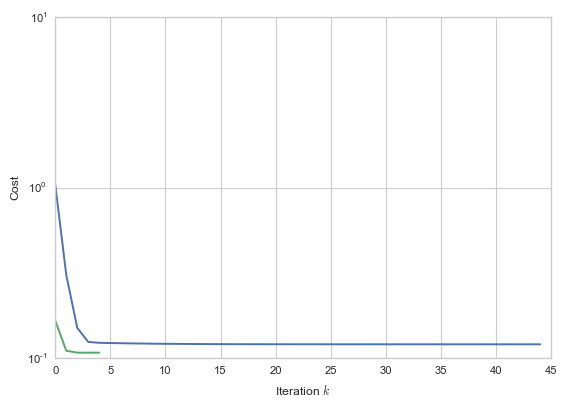

In [170]:
fig, ax = plt.subplots(1)
ax.semilogy(pd.DataFrame(summaries_noisy[argmax_noisy]['iterations'])['cost'], label=' ')
ax.semilogy(pd.DataFrame(summaries_noisy[argmin_noisy]['iterations'])['cost'], label=' ')
# legend = ax.legend(frameon=False)
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')
plt.savefig('/Users/lars/plots/points-nonoise.pdf')

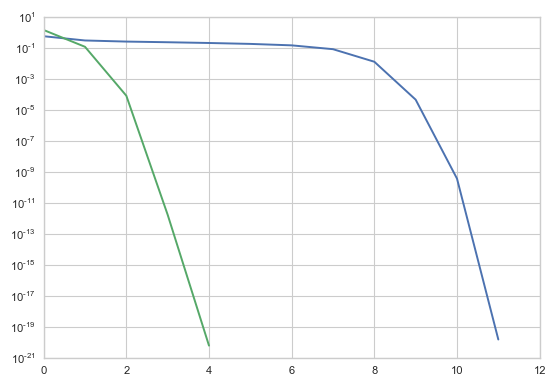

In [171]:
semilogy(pd.DataFrame(summaries[argmax]['iterations'])['cost'])
semilogy(pd.DataFrame(summaries[argmin]['iterations'])['cost'])

# Estimate motors from line observations

In [172]:
def create_random_lines(motor, n_lines=10, points_std=0.8, noise_std=0.009):
    lines = []
    for i in range(n_lines):
        a = vsr.Dll(vsr.Vec(*np.random.uniform(-1,1,3)).null(), 
                    vsr.Vec(*np.random.uniform(-1,1,3)).unit())
        
#         a = vsr.Dll(vsr.Vec(*np.random.normal(0.0,points_std,3)).null(),
#                     vsr.Vec(*np.random.uniform(-1,1,3)).unit())
        b = a.spin(motor)
        noise_motor = (vsr.Vec(*np.random.normal(0.0, noise_std,3)).trs() *
                       vsr.Rot(vsr.Biv(*np.random.uniform(-1,1,3)).unit() * np.random.uniform(-0.1, 0.1) * -0.5))
        bn = b.spin(noise_motor)
        lines.append((a,b,bn))
    return (lines, motor)

In [173]:
def estimate_motors_lines(dataset, 
                          initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                          noisy=False):
    lines, motor = dataset
    mes = MotorEstimationSolver(initial_motor)
    if noisy:
        for (a, _, bn) in lines:
            mes.add_line_angle_distance_residual_block(a,bn)
    else:
        for (a, b, _) in lines:
            mes.add_line_angle_distance_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = 'DENSE_QR'
    (estimated_motor, summary, _) = mes.solve()
    return (lines, motor, estimated_motor, summary)

In [174]:
def estimate_motors_lines_vd(dataset, 
                             initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                             noisy=False):
    vd = VDMotorEstimationSolver()
    lines, motor = dataset
    lines_a = []
    lines_b = []
    lines_bn = []
    for (a,b,bn) in lines:
        lines_a.append(a)
        lines_b.append(b)
        lines_bn.append(bn)
    if noisy:
        vd.add_dual_line_observations(lines_a, lines_bn)
    else:
        vd.add_dual_line_observations(lines_a, lines_b)
    estimated_motor = vd.solve()
    return (lines, motor, estimated_motor, [])

In [175]:
def daniilidis_motor(LAs, LBs):
    Ds = []
    for LA, LB in zip(LAs, LBs):
        D = np.zeros((8,8))
        for i in range(8):
            ei = vsr.Mot(0,0,0,0,0,0,0,0)
            ei[i] = 1.0
            D[:,i] = np.array(ei * LA - LB * ei)
        Ds.append(D[1:7,:].copy())

    
    Ds = np.array(Ds).reshape(-1,8)
    [U, s, Vt] = np.linalg.svd(Ds)

    v7 = Vt.T[:,-2].copy()
    v8 = Vt.T[:,-1].copy()
    
    v7 = np.array([v7[0], v7[3], -v7[2], v7[1], -v7[7],v7[4], v7[5], v7[6]])
    v8 = np.array([v8[0], v8[3], -v8[2], v8[1], -v8[7],v8[4], v8[5], v8[6]])
    
    u1 = v7[:4]
    v1 = v7[4:]
    u2 = v8[:4]
    v2 = v8[4:]

    a = np.inner(u1,v1)
    b = np.inner(u1,v2) + np.inner(u2,v1)
    c = np.inner(u2,v2)
    [s1, s2] = np.roots([a,b,c])

    val1 = (s1**2 * np.inner(u1,u1)) + (2 * s1 * np.inner(u1,u2)) + (np.inner(u2,u2))
    val2 = (s2**2 * np.inner(u1,u1)) + (2 * s2 * np.inner(u1,u2)) + (np.inner(u2,u2))
    
    if val1 > val2:
        s = s1
        val = val1
    else:
        s = s2
        val = val2

    lambda2 = np.sqrt(1./val)
    lambda1 = s * lambda2
    
    m_arr = lambda1 * Vt.T[:,-2] + lambda2 * Vt.T[:,-1]

    return vsr.Mot(*m_arr)

In [176]:
def estimate_motors_lines_daniilidis(dataset, 
                             initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                             noisy=False):
    lines, motor = dataset
    lines_a = []
    lines_b = []
    lines_bn = []
    for (a,b,bn) in lines:
        lines_a.append(a)
        lines_b.append(b)
        lines_bn.append(bn)
    if noisy:
        estimated_motor = daniilidis_motor(lines_a, lines_bn)
    else:
        estimated_motor = daniilidis_motor(lines_a, lines_b)
    return (lines, motor, estimated_motor, [])

In [177]:
def run_lines(n_lines=10, n_sets=10, n_motors=10, noise_std=0.09, points_std=0.08, noisy=False):
    motors = create_motors(n_motors, d_lims=(-1,1), th_lims=(-pi,pi))
    results = []
    results_vd = []
    results_daniilidis = []
    for n_set in range(n_sets):
        datasets = [create_random_lines(motor, n_lines, noise_std=noise_std, points_std=points_std) 
                    for motor in motors]
        for dataset in datasets:
            results.append(estimate_motors_lines(dataset, noisy=noisy))
            results_vd.append(estimate_motors_lines_vd(dataset, noisy=noisy))
            results_daniilidis.append(estimate_motors_lines_daniilidis(dataset, noisy=noisy))
    return (results, results_vd, results_daniilidis)

In [178]:
(results_lines, results_lines_vd, results_lines_daniilidis) = run_lines(20,20,20,noisy=False)
print(results_lines[1][1], results_lines[1][2])
print(results_lines_daniilidis[1][1], results_lines_daniilidis[1][2])
print(results_lines_vd[1][1], results_lines_vd[1][2])

Mot: [ 0.062 -0.13 0.1 -0.98 -0.036 -0.014 0.23 0.1 ] Mot: [ 0.062 -0.13 0.1 -0.98 -0.036 -0.014 0.23 0.1 ]
Mot: [ 0.062 -0.13 0.1 -0.98 -0.036 -0.014 0.23 0.1 ] Mot: [ 0.062 -0.13 0.1 -0.98 -0.036 -0.014 0.23 0.1 ]
Mot: [ 0.062 -0.13 0.1 -0.98 -0.036 -0.014 0.23 0.1 ] Mot: [ 0.062 -0.13 0.1 -0.98 0 0 0 0 ]


In [179]:
wrong_results = []
n1s = []
for (_, m, em, _) in results_lines:
    norm = np.linalg.norm(m * em.rev())
    n1s
    if norm > 1.00001:
        wrong_results.append((m,em, norm))
print(len(wrong_results))

2


In [180]:
dataset = []
dataset_daniilidis = []
for result, resultd in zip(results_lines, results_lines_daniilidis):
    (ls, m, em, s) = result
    ps, _ = create_gaussian_points(m)
    dataset.append((ps, m, em, s))
    (lsd, md, emd, sd) = resultd
    dataset_daniilidis.append((ps, md, emd, sd))

In [181]:
rms(dataset)

(0.041704387706291639, 0.63328899254471682)

In [182]:
rms(dataset_daniilidis)

(6.4039678920660788e-16, 2.9043667635787091e-16)

In [183]:
for m, em, _ in wrong_results:
    print(np.arctan2(m.dll().biv().norm(), m[0]) * 2.0, m.trs())

3.1405904907 Vec: [ -0.36 -0.54 -0.43 ]
3.1405904907 Vec: [ -0.36 -0.54 -0.43 ]


# Planes

In [184]:
def create_random_planes(motor, n_planes=10, points_std=0.8, noise_std=0.009):
    planes = []
    for i in range(n_planes):
        dir_vec = vsr.Vec(*np.random.uniform(-1,1,3)).unit()
        distance = np.random.uniform(-1,1)
        a = vsr.Dlp(dir_vec,distance)
        b = a.spin(motor)
        noise_motor = (vsr.Vec(*np.random.normal(0.0, noise_std,3)).trs() *
                       vsr.Rot(vsr.Biv(*np.random.uniform(-1,1,3)).unit() * np.random.uniform(-0.1, 0.1) * -0.5))
        bn = b.spin(noise_motor)
        planes.append((a,b,bn))
    return (planes, motor)

In [185]:
def estimate_motors_planes(dataset, 
                           initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                           noisy=False):
    planes, motor = dataset
    mes = MotorEstimationSolver(initial_motor)
    if noisy:
        for (a, _, bn) in planes:
            mes.add_dual_plane_difference_residual_block(a,bn)
#             mes.add_dual_plane_angle_error_residual_block(a,bn)
    else:
        for (a, b, _) in planes:
#             mes.add_dual_plane_angle_error_residual_block(a,b)
            mes.add_dual_plane_difference_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = 'DENSE_QR'
    (estimated_motor, summary, _) = mes.solve()
    return (planes, motor, estimated_motor, summary)

In [186]:
def run_planes(n_planes=10, n_sets=10, n_motors=10, noise_std=0.09, points_std=0.08, noisy=False):
    motors = create_motors(n_motors, d_lims=(-1,1), th_lims=(-pi,pi))
    results = []
    results_vd = []
    results_daniilidis = []
    for n_set in range(n_sets):
        datasets = [create_random_planes(motor, n_planes, noise_std=noise_std, points_std=points_std) 
                    for motor in motors]
        for dataset in datasets:
            results.append(estimate_motors_planes(dataset, noisy=noisy))
    return (results, results_vd, results_daniilidis)

In [191]:
(results_planes, _, _) = run_planes(4,100,100,noisy=False)
print(results_planes[1][1], results_planes[1][2])

Mot: [ 0.36 -0.082 -0.81 0.46 0.094 0.003 -0.0076 0.13 ] Mot: [ 0.36 -0.082 -0.81 0.46 0.094 0.003 -0.0076 0.13 ]


In [192]:
dataset = []
for result in results_planes:
    (ls, m, em, s) = result
    ps, _ = create_gaussian_points(m)
    dataset.append((ps, m, em, s))

In [193]:
rms(dataset)

(1.4706913054464252e-09, 3.9409420298990868e-09)

In [194]:
wrong_results = []
n1s = []
for (_, m, em, _) in results_planes:
    norm = np.linalg.norm(m * em.rev())
    if norm > 1.00001:
        wrong_results.append((m,em, norm))
print(len(wrong_results))

0


In [146]:
for m, em, _ in wrong_results:
    print(np.arctan2(m.dll().biv().norm(), m[0]) * 2.0, m.trs())

# Heterogeneous Sets

In [ ]:
def estimate_motors_heterogenepus(dataset, 
                                  initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                                  noisy=False):
    planes, motor = dataset
    mes = MotorEstimationSolver(initial_motor)
    if noisy:
        for (a, _, bn) in planes:
            mes.add_dual_plane_difference_residual_block(a,bn)
#             mes.add_dual_plane_angle_error_residual_block(a,bn)
    else:
        for (a, b, _) in planes:
#             mes.add_dual_plane_angle_error_residual_block(a,b)
            mes.add_dual_plane_difference_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = 'DENSE_QR'
    (estimated_motor, summary, _) = mes.solve()
    return (planes, motor, estimated_motor, summary)

In [147]:
def run_heterogeneous(n_points=10, n_lines=10, n_planes=10, n_sets=10, n_motors=10, noise_std=0.09, points_std=0.08, noisy=False):
    motors = create_motors(n_motors, d_lims=(-1,1), th_lims=(-pi,pi))
    results = []
    results_vd = []
    for n_set in range(n_sets):
        point_datasets = [create_random_planes(motor, n_points, noise_std=noise_std, points_std=points_std) 
                    for motor in motors]
        line_datasets = [create_random_lines(motor, n_lines, noise_std=noise_std, points_std=points_std) 
                    for motor in motors]
        plane_datasets = [create_random_planes(motor, n_planes, noise_std=noise_std, points_std=points_std) 
                    for motor in motors]
        
        for dataset in datasets:
            results.append(estimate_motors_planes(dataset, noisy=noisy))
    return (results, results_vd, results_daniilidis)